In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# import california housing dataset
california_housing = fetch_california_housing(as_frame=True)
california_housing.data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
# define target value
california_housing.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [4]:
# check dataset for missing values and get basic info
california_housing.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


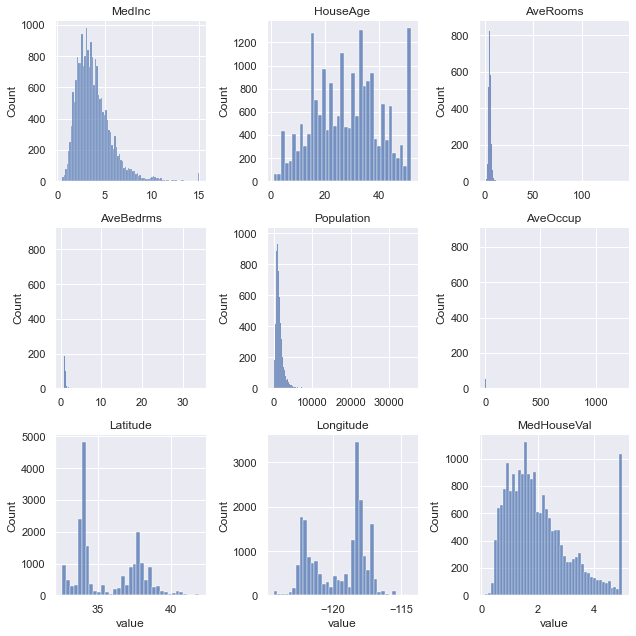

In [5]:
# build feature histograms to indificate distribution type and abnormal values
sns.set_theme()

melted = california_housing.frame.melt()

g = sns.FacetGrid(melted,
                  col='variable',
                  col_wrap=3,
                  sharex=False,
                  sharey=False)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    g.map(sns.histplot, 'value')

g.set_titles(col_template='{col_name}')

g.tight_layout()

plt.show()

In [6]:
# describe basic features
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
california_housing.frame[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


In [7]:
# delete abnormal values from dataset
df_zscore_averooms = zscore(california_housing.data['AveRooms'], nan_policy='omit')
df_zscore_avebedrms = zscore(california_housing.data['AveBedrms'], nan_policy='omit')
df_zscore_aveoccup = zscore(california_housing.data['AveOccup'], nan_policy='omit')
df_zscore_population = zscore(california_housing.data['Population'], nan_policy='omit')

df_zscore_averooms
df_zscore_averooms.describe()

# get the row where AveRooms=8.288136
#california_housing.data[california_housing.data['AveRooms']==8.288136]

# ??????????????????????????????????????????????????????????????????????

# to get row index
#row_index=california_housing.data.index[california_housing.data['AveRooms']==8.288136].tolist()
#row_index

# substitute values that are greater in 3-sigma times
#california_housing.data['AveRooms']=california_housing.data['AveRooms'].apply(lambda x: x if df_zscore_averooms[raw_index]<3 AND df_zscore_averooms[raw_index]>-3   else california_housing.data['AveRooms'].mean() )



#outliers=np.where(df_zscore_averooms.between(-3,3))
#outliers

california_housing.data['AveRooms'].describe()

count    20640.000000
mean         5.429000
std          2.474173
min          0.846154
25%          4.440716
50%          5.229129
75%          6.052381
max        141.909091
Name: AveRooms, dtype: float64

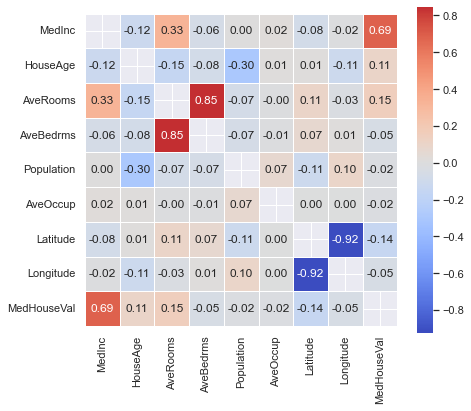

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,-122.25


In [8]:
# build correlation matrix
corr_mtx = california_housing.frame.corr()

mask_mtx = np.zeros_like(corr_mtx)
np.fill_diagonal(mask_mtx, 1)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(corr_mtx,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            linewidth=0.5,
            square=True,
            mask=mask_mtx,
            ax=ax)

plt.show()

# 'Latitude' and 'Longitude' feature have hight positive correlation. Let's delete 'Latitude' feature from our model
california_housing_new=california_housing.data.drop(columns=['Latitude'])

california_housing_new.head()

In [9]:
# split on train and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    california_housing_new,
    california_housing.target,
    test_size=0.2,
    random_state=42)

In [10]:
# perform data normalisation
scaler = StandardScaler().set_output(transform='pandas').fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

X_train_scaled.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Longitude
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-6.519333e-17,-9.251859e-18,-1.981081e-16,-1.707291e-16,-2.151595e-19,4.936566e-17,1.753335e-15
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-1.775438e+00,-2.190766e+00,-1.904386e+00,-1.762117e+00,-1.251913e+00,-2.076846e-01,-2.377207e+00
25%,-6.900689e-01,-8.417859e-01,-4.118373e-01,-2.081645e-01,-5.606339e-01,-5.770769e-02,-1.110749e+00
50%,-1.758995e-01,3.108328e-02,-8.350905e-02,-1.094160e-01,-2.281865e-01,-2.415892e-02,5.346501e-01
75%,4.686502e-01,6.658972e-01,2.621376e-01,8.455177e-03,2.634487e-01,1.580865e-02,7.839530e-01
max,5.839268e+00,1.856173e+00,5.716655e+01,5.664727e+01,3.012743e+01,1.071164e+02,2.628794e+00


In [11]:
# build a model
model = LinearRegression().fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
ymin, ymax = y_train.agg(['min', 'max']).values
y_pred=pd.Series(y_pred, index=X_test_scaled.index).clip(ymin, ymax)
y_pred.head()

20046    0.990408
3024     1.559220
15663    2.737375
20484    2.632012
9814     2.026329
dtype: float64

In [12]:
# model accuracy estimation
r_sq=model.score(X_train_scaled, y_train)
mae=mean_absolute_error(y_test, y_pred)
mape=mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.55 | MAE: 0.56 | MAPE: 0.35
